<a href="https://colab.research.google.com/github/argennof/M_Predi_Lluvias_Extremas_10/blob/main/TP3_Balbuena_Serrantes_Fonnegra_Velazquez.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## TP3: Introducción al aprendizaje automático

De los datasets analizados en los TPs anteriores, ahora nos vamos a enfocar en:

- La Florida
- Marcos Juarez

Y vamos a usar como variable que queremos predecir, la PMDA que han calculado para cada año hidrológico (del 1/julio al 30/junio).

Las demás variables (como viento, temperatura, etc) las vamos a resumir para cada año hidrológico en la media (se pueden agregar más estadísticos pero así es suficiente).

##### Actividades:

##### OBJETIVO: Predecir Precipitación Máxima Diaria Anual (PMDA) para los próximos 5 años

1) De los dataset que han trabajado hasta ahora, agreguen más features al DataFrame **"Datos"** (Por lo general, más features tienden a dar mejores predicciones).

2) Además de las features del punto anterior, les propongo agregar nuevas features moviendo las originales tantos "pasos de tiempo" como features nuevas quieran generar.

3) Curar el dataset (si fuera necesario).

4) Aplicar técnicas de selección y extraccion de features. Armar un nuevo dataset con aquellas features más significativas.

5) Dividir el dataset (training, validation, test).. Recuerden que queremos predecir la PMDA para los próximos 5 años.

6) Analizar y elegir 3 modelos para REGRESIÓN. Entrenarlos y analizar resultados.

7) Evaluar predicciones de los diferentes modelos.

8) ¿Qué estadísticos utilizaron para evaluar las regresiones? Justifiquen su elección.


Busqueda en internet:

https://towardsdatascience.com/predicting-rain-with-machine-learning-2acf80017c44

https://www.kaggle.com/code/nasirmeh/prediction-of-rainfall

https://www.kaggle.com/code/fahadmehfoooz/rain-prediction-with-90-65-accuracy

https://www.kaggle.com/code/chandrimad31/rainfall-prediction-7-popular-models

1- Configuración de las librerías necesarías para el desarrollo del trabajo:

In [1]:
import warnings
warnings.filterwarnings("ignore")

## For data
import pandas as pd
import numpy as np

## For plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
sns.set_context("notebook", font_scale=1.25)

## For outliers detection
from sklearn import preprocessing, svm
## For stationarity test and decomposition
import statsmodels.tsa.api as smt
import statsmodels.api as sm

- Carga de datos:

In [2]:
Datos = pd.read_csv("https://raw.githubusercontent.com/Rondamon/2022_Mentoria_LluviasExtremas\
/master/dataset/datos_diarios_cordoba.csv", parse_dates = True, index_col="fecha")
id_Datos = pd.read_csv("https://raw.githubusercontent.com/Rondamon/2022_Mentoria_LluviasExtremas\
/master/dataset/metadatos_estaciones.csv")

- Creando el diccionario de datos:

In [3]:
stations_dataset = id_Datos.copy()
dataset = Datos.copy()
stations = stations_dataset.set_index('omm_id')['nombre'].to_dict()
print(stations)
elevs = stations_dataset.set_index('omm_id')['elev'].to_dict()
print(elevs)

{87244: 'Villa Maria del Rio Seco', 87328: 'Villa Dolores Aero', 87344: 'Cordoba Aero', 87345: 'Cordoba Obs.', 87349: 'Pilar Obs.', 87466: 'Marcos Juarez INTA', 87453: 'Rio Cuarto Aero', 87467: 'Marcos Juarez Aero', 87534: 'Laboulaye Aero', 9987009: 'Manfredi INTA', 9987013: 'Capilla del Monte INTA', 9987015: 'Canals INTA', 1: 'La Florida', 2: 'Pueblo Andino'}
{87244: 341, 87328: 569, 87344: 474, 87345: 426, 87349: 338, 87466: 110, 87453: 421, 87467: 114, 87534: 137, 9987009: 292, 9987013: 984, 9987015: 125, 1: 1090, 2: 9}


- Incorporando el nombre de la estación y su correspondiente elevación:

In [4]:
dataset_with_stations = dataset.copy()
dataset_with_stations['station'] = dataset_with_stations['omm_id'].replace(stations)
dataset_with_stations['station_elev'] = dataset_with_stations['omm_id'].replace(elevs)
dataset_with_stations.reset_index(inplace=True)


- Filtrado de datos para estaciones de interes:

In [5]:
# datos_dcor_filtered = dataset_with_stations.query('omm_id == 87467|omm_id ==1')
# 87244 - Villa Maria del rio seco & Marcos juarez -87467
datos_dcor_filtered = dataset_with_stations.query('omm_id == 87467|omm_id == 87244')
datos_dcor_filtered.head(3)
datos_dcor_filtered.reset_index(inplace=True)
datos_dcor_filtered.drop(['index'], axis=1, inplace=True)
datos_dcor_filtered

,fecha,id,omm_id,helio,hr,nub,prcp,pres_est,pres_nm,td,tmax,tmed,tmin,vmax_d,vmax_f,vmed,caudal,station,station_elev
0,1961-01-01,1,87244,NaN,62.0,0.0,0.0,965.9,NaN,15.9,32.3,25.1,13.5,NaN,NaN,1.0,NaN,Villa Maria del Rio Seco,341
1,1961-01-02,2,87244,NaN,66.0,6.0,28.0,969.9,NaN,15.5,27.5,22.2,18.3,NaN,NaN,1.0,NaN,Villa Maria del Rio Seco,341
2,1961-01-03,3,87244,NaN,92.0,8.0,15.4,972.6,NaN,13.1,21.7,14.4,12.9,NaN,NaN,4.5,NaN,Villa Maria del Rio Seco,341
3,1961-01-04,4,87244,NaN,84.0,5.0,0.0,969.6,NaN,17.4,23.1,20.4,13.9,NaN,NaN,0.3,NaN,Villa Maria del Rio Seco,341
4,1961-01-05,5,87244,NaN,84.0,5.0,3.6,965.6,NaN,17.8,23.9,20.7,15.5,NaN,NaN,1.5,NaN,Villa Maria del Rio Seco,341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43109,2020-01-04,169736,87467,11.6,76.0,1.0,0.0,997.3,1010.4,17.8,30.0,22.8,15.6,5.0,8.2,3.3,NaN,Marcos Juarez Aero,114
43110,2020-01-05,169737,87467,12.0,73.0,4.0,29.0,988.9,1002.0,18.2,31.2,23.9,15.4,27.0,21.6,4.6,NaN,Marcos Juarez Aero,114
43111,2020-01-06,169738,87467,8.0,76.0,6.0,0.0,994.0,1007.2,14.3,26.1,19.6,15.6,9.0,8.2,4.4,NaN,Marcos Juarez Aero,114
43112,2020-01-07,169739,87467,11.7,68.0,0.0,0.0,995.1,1008.4,14.0,30.3,20.9,11.1,2.0,7.2,3.0,NaN,Marcos Juarez Aero,114


- Calculo de los valores faltantes:

In [6]:
missing_values_count = datos_dcor_filtered.isna().sum()
missing_values_count.sort_values()

fecha               0
station             0
station_elev        0
id                  0
omm_id              0
prcp              146
vmed              407
nub               408
tmed              422
td                763
hr                809
pres_est         1150
tmax             1234
tmin             3506
vmax_f           5948
vmax_d           5949
pres_nm         14103
helio           22728
caudal          43114
dtype: int64

- Estimamos el porcentaje de datos faltantes y los visualizamos:

In [7]:
# how many total missing values do we have?
total_cells = np.product(datos_dcor_filtered.shape)
total_missing = missing_values_count.sum()

# percent of data that is missing
print(f'porcentaje de faltantes en la base de datos: {((total_missing/total_cells) * 100):2f}')

porcentaje de faltantes en la base de datos: 12.291404


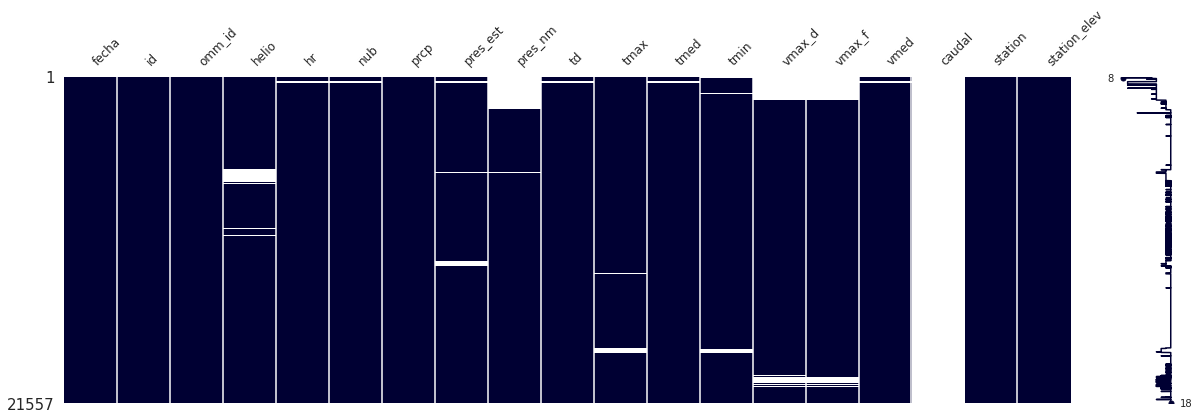

In [8]:
import missingno as msno
msno.matrix(datos_dcor_filtered.query('omm_id == 87467'),figsize=(20, 6), fontsize=12, color=[0,0,0.2])

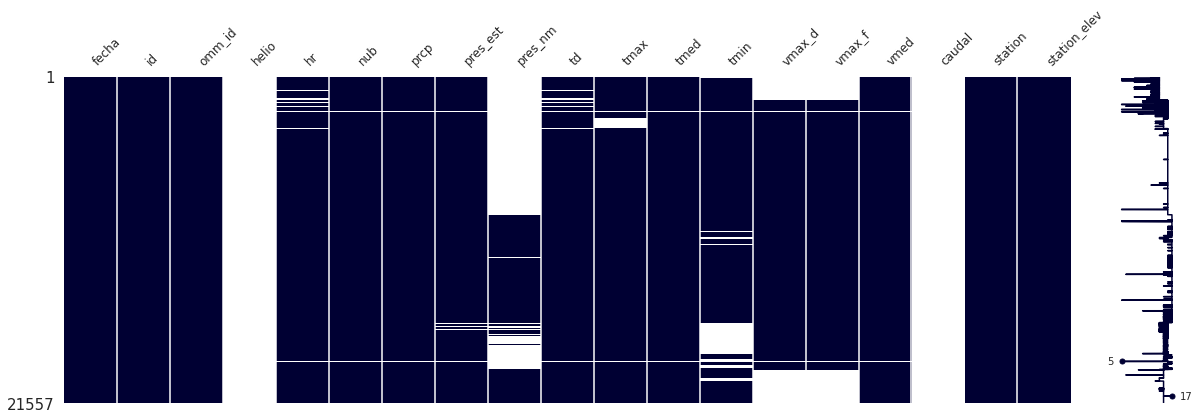

In [9]:
import missingno as msno
msno.matrix(datos_dcor_filtered.query('omm_id == 87244'),figsize=(20, 6), fontsize=12, color=[0,0,0.2])

- Dado que caudal es una columna que no presenta información decidimos eliminarla del conjunto:

In [10]:
# datos_dcor_filtered.columns.tolist()
datos_dcor_filtered.drop(['caudal','helio'], axis=1, inplace=True)

In [11]:
datos_dcor_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43114 entries, 0 to 43113
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   fecha         43114 non-null  datetime64[ns]
 1   id            43114 non-null  int64         
 2   omm_id        43114 non-null  int64         
 3   hr            42305 non-null  float64       
 4   nub           42706 non-null  float64       
 5   prcp          42968 non-null  float64       
 6   pres_est      41964 non-null  float64       
 7   pres_nm       29011 non-null  float64       
 8   td            42351 non-null  float64       
 9   tmax          41880 non-null  float64       
 10  tmed          42692 non-null  float64       
 11  tmin          39608 non-null  float64       
 12  vmax_d        37165 non-null  float64       
 13  vmax_f        37166 non-null  float64       
 14  vmed          42707 non-null  float64       
 15  station       43114 non-null  object

- Prueba - Imputacion:

In [12]:
# Objetos - codigo:
datos_dcor_a = datos_dcor_filtered.loc[:,['omm_id','id','fecha','station','prcp', 'station_elev']]
print(datos_dcor_a.columns)
datos_dcor_num = datos_dcor_filtered.select_dtypes(include=['int', 'float'])
datos_dcor_num.drop(['prcp','station_elev'], axis=1, inplace=True)
print(datos_dcor_num.columns)

Index(['omm_id', 'id', 'fecha', 'station', 'prcp', 'station_elev'], dtype='object')
Index(['id', 'omm_id', 'hr', 'nub', 'pres_est', 'pres_nm', 'td', 'tmax',
       'tmed', 'tmin', 'vmax_d', 'vmax_f', 'vmed'],
      dtype='object')


In [13]:
db_87467 = datos_dcor_num.query('omm_id == 87467')
db_87244 = datos_dcor_num.query('omm_id == 87244')

In [14]:
from sklearn import preprocessing 

scaler = preprocessing.RobustScaler()
robust_87467 = scaler.fit_transform(db_87467)
robust_87467 = pd.DataFrame(robust_87467, columns=db_87467.columns)

from sklearn.experimental import enable_iterative_imputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import IterativeImputer

imputer = IterativeImputer(random_state=0, estimator=KNeighborsRegressor(),n_nearest_features=5)
values_87467 = robust_87467.values.copy()
# Matriz escalada
scaled_knn_87467 = imputer.fit_transform(values_87467)
inver_imputa_87467 = pd.DataFrame(scaler.inverse_transform(scaled_knn_87467), columns=db_87467.columns)

In [15]:
# from sklearn import preprocessing 
# from sklearn.experimental import enable_iterative_imputer
# from sklearn.neighbors import KNeighborsRegressor
# from sklearn.impute import IterativeImputer

scaler = preprocessing.RobustScaler()
robust_87244 = scaler.fit_transform(db_87244)
robust_87244 = pd.DataFrame(robust_87244, columns=db_87244.columns)

imputer = IterativeImputer(random_state=0, estimator=KNeighborsRegressor(),n_nearest_features=5)
values_87244 = robust_87244.values.copy()

# Matriz escalada
scaled_knn_87244 = imputer.fit_transform(values_87244)
inver_imputa_87244 = pd.DataFrame(scaler.inverse_transform(scaled_knn_87244), columns=db_87244.columns)

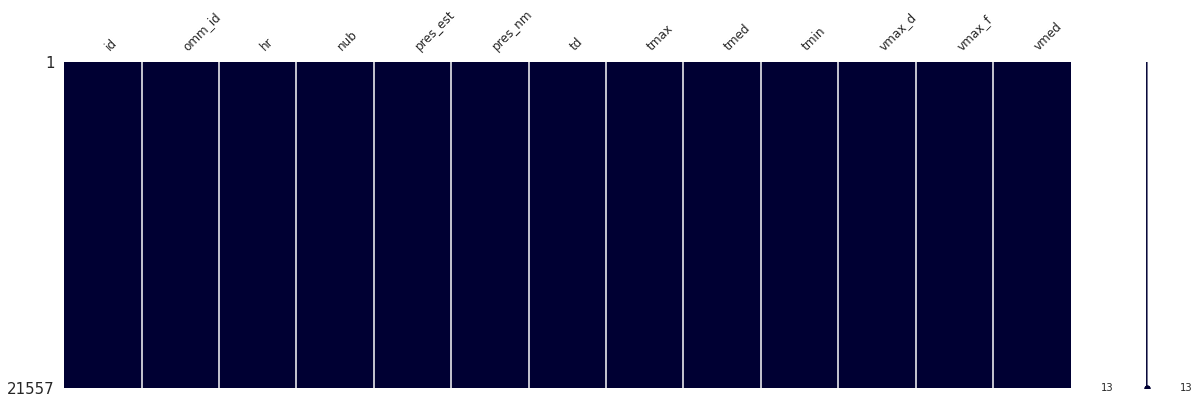

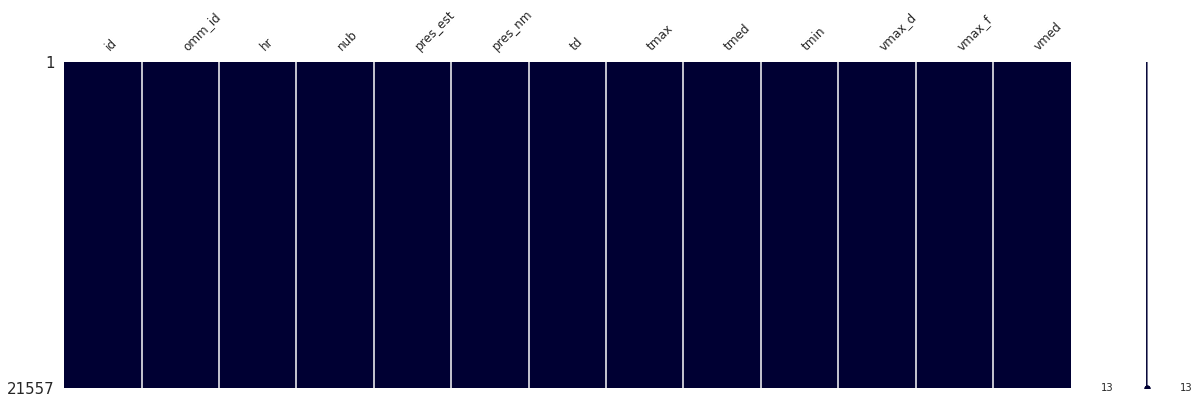

In [ ]:
import missingno as msno
msno.matrix(inver_imputa_87467,figsize=(20, 6), fontsize=12, color=[0,0,0.2])
msno.matrix(inver_imputa_87244,figsize=(20, 6), fontsize=12, color=[0,0,0.2])

In [16]:
df_concat = pd.concat([inver_imputa_87244,inver_imputa_87467])

In [17]:
df_concat.reset_index(inplace=True)
df_concat.omm_id =	df_concat.omm_id.astype(int)
df_concat.id =	df_concat.id.astype(int)
df_concat.drop(['index'], axis=1, inplace=True)

In [18]:
df_concat.head(2)

,id,omm_id,hr,nub,pres_est,pres_nm,td,tmax,tmed,tmin,vmax_d,vmax_f,vmed
0,1,87244,62.0,0.0,965.9,1004.60,15.9,32.3,25.1,13.5,17.8,2.28,1.0
1,2,87244,66.0,6.0,969.9,1008.16,15.5,27.5,22.2,18.3,14.8,1.32,1.0


In [19]:
datos_dcor_clean = datos_dcor_a.merge(df_concat, on=['omm_id','id'])

In [20]:
datos_dcor_clean.head(3)

,omm_id,id,fecha,station,prcp,station_elev,hr,nub,pres_est,pres_nm,td,tmax,tmed,tmin,vmax_d,vmax_f,vmed
0,87244,1,1961-01-01,Villa Maria del Rio Seco,0.0,341,62.0,0.0,965.9,1004.60,15.9,32.3,25.1,13.5,17.8,2.28,1.0
1,87244,2,1961-01-02,Villa Maria del Rio Seco,28.0,341,66.0,6.0,969.9,1008.16,15.5,27.5,22.2,18.3,14.8,1.32,1.0
2,87244,3,1961-01-03,Villa Maria del Rio Seco,15.4,341,92.0,8.0,972.6,1012.16,13.1,21.7,14.4,12.9,9.8,6.70,4.5


In [21]:
print(datos_dcor_clean.columns)
datos_dcor_clean = datos_dcor_clean[['id','fecha','omm_id','station','station_elev','prcp','hr', 'nub',\
                                     'pres_est', 'pres_nm', 'td', 'tmax', 'tmed', 'tmin', 'vmax_d', 'vmax_f',\
                                     'vmed',]]
datos_dcor_clean.head(1)

Index(['omm_id', 'id', 'fecha', 'station', 'prcp', 'station_elev', 'hr', 'nub',
       'pres_est', 'pres_nm', 'td', 'tmax', 'tmed', 'tmin', 'vmax_d', 'vmax_f',
       'vmed'],
      dtype='object')


,id,fecha,omm_id,station,station_elev,prcp,hr,nub,pres_est,pres_nm,td,tmax,tmed,tmin,vmax_d,vmax_f,vmed
0,1,1961-01-01,87244,Villa Maria del Rio Seco,341,0.0,62.0,0.0,965.9,1004.6,15.9,32.3,25.1,13.5,17.8,2.28,1.0


- A partir de la función que define el año hidrológico-> 1/agosto al 31/julio


In [22]:
def get_hydro_year(date_, start_month=7):
    year = date_.strftime('%Y')
    month = date_.strftime('%m')
    offset = 1 if int(month) >= start_month - 1 else 0
    hydro_year = int(year) + offset - 1
    return hydro_year

In [59]:
datos_dcor_clean['hydro_year'] = datos_dcor_clean['fecha'].apply(lambda fecha: get_hydro_year(fecha))



# .resample(temp_w) - ojo


- nub: cobertura nubosa (octavos).
- prcp: precipitación acumulada (milímetros "mm").
- pres_est: presión al nivel de la estación (hectopascales "hpa").
- pres_nm: presión al nivel del mar (hectopascales "hpa").
- td: temperatura de rocio (Grados Celsius).
- tmax: temperatura máxima (Grados Celsius).
- tmed: temperatura media (Grados Celsius).
- tmin: temperatura mínima (Grados Celsius).
- vmax_d: dirección del viento máximo (decenas de grado).
- vmax_f: velocidad del viento máxima (metros por segundo "m/s").
- vmed: velocidad del viento media (metros por segundo "m/s").


- Agrupo según los años - estaciones:

In [62]:
### Acumulado precipitación - Renombro:
datos_PTA_cor = datos_dcor_clean[['hydro_year','omm_id','prcp']].groupby(['hydro_year', 'omm_id']).sum()
datos_PTA_cor.rename(columns={'prcp':'prcp_PTA'},inplace=True)

### Máximos por variable - PMDA - Renombro: 
datos_max_cor = datos_dcor_clean[['hydro_year','omm_id','prcp','hr','nub','tmax','vmax_d','vmax_f',\
                                   'pres_est','pres_nm','td']].groupby(['hydro_year', 'omm_id']).max()

datos_max_cor.rename(columns={'prcp':'prcp_PMDA','hr':'hr_max_hy','nub':'nub_max_hy','tmax':'tmax_hy',\
                        'vmax_d':'vmax_d_hy','vmax_f':'vmax_f_hy','pres_est':'pres_est_max_hy',\
                        'pres_nm':'pres_nm_max_hy','td':'td_max_hy'},inplace=True)



In [64]:
### Mínimos por variable - PMDA - Renombro: 
datos_min_cor = datos_dcor_clean[['hydro_year','omm_id','hr','nub','tmin',
                                   'pres_est','pres_nm','td']].groupby(['hydro_year', 'omm_id']).min()

datos_min_cor.rename(columns={'hr':'hr_min_hy','nub':'nub_min_hy','tmin':'tmin_hy',\
                       'pres_est':'pres_est_min_hy','pres_nm':'pres_nm_min_hy','td':'td_min_hy'},
                     inplace=True)
                        


In [73]:
### Promedios por variable - Renombro: 
excepto =['id', 'station', 'station_elev', 'prcp','tmax','vmax_d','vmax_f','tmin']
datos_prom_cor= round(datos_dcor_clean.loc[:, datos_dcor_clean. columns.difference(excepto)
                                                         ].groupby(['hydro_year', 'omm_id']).mean(),4)

datos_prom_cor.rename(columns={'hr':'hr_prom_hy','nub':'nub_prom_hy','pres_est':'pres_est_prom_hy',\
                              'pres_nm':'pres_nm_prom_hy','td':'td_prom_hy',\
                               'tmed':'tmed_hy','vmed':'vmed_hy'},
                     inplace=True)
     

In [82]:
datos_max_cor

prcp_PMDA  hr_max_hy  nub_max_hy  tmax_hy  vmax_d_hy  \
hydro_year omm_id                                                         
1960       87244        78.0       98.0         8.0     39.7       26.4   
           87467        59.5       99.0         8.0     37.4       27.2   
1961       87244        59.5       96.0         8.0     37.4       33.6   
           87467        89.4       98.0         8.0     38.0       33.4   
1962       87244       109.0       99.0         8.0     44.6       32.2   
...                      ...        ...         ...      ...        ...   
2017       87467        68.0       99.0         8.0     39.6       36.0   
2018       87244        41.0      100.0         8.0     42.1       30.8   
           87467        99.0       99.0         8.0     37.0       36.0   
2019       87244        34.0       96.0         8.0     41.0       34.4   
           87467        75.0       98.0         8.0     37.2       36.0   

                   vmax_f_hy  pres_est_max_hy  pres_nm_max_hy  td_max_hy  
hydro_year omm_id                                                         
1960       87244       10.50            984.4         1025.30      22.40  
           87467       14.80           1011.5         1024.78      24.80  
1961       87244       11.72            990.1         1031.52      22.30  
           87467       24.48           1019.4         1033.04      22.64  
1962       87244       11.32            989.7         1031.68      22.80  
...                      ...              ...             ...        ...  
2017       87467       29.30           1017.7         1032.30      23.30  
2018       87244       12.30            993.4         1035.50      25.30  
           87467       36.00           1018.4         1032.60      25.90  
2019       87244       11.72            993.9         1035.70      22.30  
           87467       26.20           1021.4         1035.80      23.80  

[120 rows x 9 columns]

In [ ]:
# comienza codigo: https://www.dataquest.io/blog/tutorial-time-series-analysis-with-pandas/

dtf = pd.read_csv('https://github.com/argennof/M_Predi_Lluvias_Extremas_10/blob/main/bbd_pta_parte_a.csv?raw=true', sep=';')
dtf.tail(5)
# dtf["Date"] = pd.to_datetime(dtf['Date'], format='%Y-%m-%d')
# dtf.head(3)

In [ ]:
datos_dcor_filtered = dtf.query('omm_id == 87467|omm_id ==1')
# datos_dcor_filtered.info()

# Valores Faltantes:
missing_values_count = datos_dcor_filtered.isna().sum()
missing_values_count.sort_values()

In [ ]:
sns.set(rc={'figure.figsize':(11, 4)})




dtf['prcp'].plot(linewidth=0.5);

In [ ]:
cols_plot = ['Consumption', 'Solar', 'Wind']
axes = dtf[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_ylabel('Daily Totals (GWh)')

Deteccion de patrones emergentes:
-Electricity consumption is highest in winter, 



In [ ]:
ax = dtf.loc['2017', 'Consumption'].plot()
ax.set_ylabel('Daily Consumption (GWh)');


Aca inicia:
- https://towardsdatascience.com/time-series-analysis-for-machine-learning-with-python-626bee0d0205

- https://github.com/mdipietro09/DataScience_ArtificialIntelligence_Utils/blob/master/time_series/example_forecast.ipynb

In [ ]:
## create time series
ts = dtf.groupby("Date")["Consumption"].sum().rename("consumo_m")
ts.head()


In [ ]:
print("population --> len:", len(ts), "| mean:", round(ts.mean()), " | std:", round(ts.std()))
w = 30
print("moving --> len:", w, " | mean:", round(ts.ewm(span=w).mean()[-1]), " | std:", round(ts.ewm(span=w).std()[-1]))

In [ ]:
###############################################################################
#                         TS ANALYSIS                                         #
###############################################################################
'''
Plot ts with rolling mean and 95% confidence interval with rolling std.
:parameter
    :param ts: pandas Series
    :param window: num for rolling stats
    :param plot_intervals: bool - if True plots the conf interval
    :param plot_ma: bool - if True plots the moving avg
'''
def plot_ts(ts, plot_ma=True, plot_intervals=True, window=30, figsize=(15,5)):
    rolling_mean = ts.rolling(window=window).mean()
    rolling_std = ts.rolling(window=window).std()
    plt.figure(figsize=figsize)
    plt.title(ts.name)
    plt.plot(ts[window:], label='ts', color="black")
    if plot_ma:
        plt.plot(rolling_mean, 'g', label='MA'+str(window), color="red")
    if plot_intervals:
        lower_bound = rolling_mean - (1.96 * rolling_std)
        upper_bound = rolling_mean + (1.96 * rolling_std)
        plt.fill_between(x=ts.index, y1=lower_bound, y2=upper_bound, color='lightskyblue', alpha=0.4)
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()


plot_ts(ts, plot_ma=True, plot_intervals=True, window=w, figsize=(15,5))

In [ ]:
def utils_generate_rw(y0, n, sigma, ymin=None, ymax=None):
    rw = [y0]
    for t in range(1, n):
        yt = rw[t-1] + np.random.normal(0,sigma)
        if (ymax is not None) and (yt > ymax):
            yt = rw[t-1] - abs(np.random.normal(0,sigma))
        elif (ymin is not None) and (yt < ymin):
            yt = rw[t-1] + abs(np.random.normal(0,sigma))
        rw.append(yt)
    return rw

'''
Forecast unknown future.
:parameter
    :param ts: pandas series
    :param pred_ahead: number of observations to forecast (ex. pred_ahead=30)
    :param end: string - date to forecast (ex. end="2016-12-31")
    :param zoom: for plotting
:return
    dtf with columns "ts", "model", "residuals", "lower", "forecast", "upper" (No error)
'''
def forecast_rw(ts, pred_ahead=None, end=None, conf=0.95, zoom=30, figsize=(15,5)):
    ## fit
    diff_ts = ts - ts.shift(1)
    sigma = diff_ts.std()
    rw = utils_generate_rw(y0=ts[0], n=len(ts), sigma=sigma, ymin=ts.min(), ymax=ts.max())
    dtf = ts.to_frame(name="ts").merge(pd.DataFrame(rw, index=ts.index, columns=["model"]), 
                                       how='left', left_index=True, right_index=True)
    
    ## index
    freq = ts.index.inferred_freq[0]
    index = utils_generate_indexdate(start=ts.index[-1], end=end, n=pred_ahead, freq=freq)
    
    ## forecast
    preds = utils_generate_rw(y0=ts[-1], n=len(index), sigma=sigma, ymin=ts.min(), ymax=ts.max())
    dtf = dtf.append(pd.DataFrame(data=preds, index=index, columns=["forecast"]))
    
    ## add intervals and plot
    dtf = utils_add_forecast_int(dtf, conf=conf, zoom=zoom)
    return dtf
    
